In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

def characteristic_time_mode(n: int, R: float, Cm: float, Cs: float, N: int, closed: bool)->float:
    """Characteristic Time of mode n in a string of N Nanoparticles

    Parameters
    ----------
    n : int
        nth mode [1,N]
    R : float
        Junction resistance
    Cm : float
        Mutual capacitance
    Cs : float
        Self capacitance
    N : int
        Number of Nanoparticles in String
    closed : bool
        If last not is grounded or not

    Returns
    -------
    float
        Characteristic mode time scale
    """
    if closed:
        a   = R*(Cs+2*Cm*(1-np.cos(n*np.pi/(N+1))))
        b   = 2*(1-np.cos(n*np.pi/(N+1)))
    else:
        a   = R*(Cs+2*Cm*(1-np.cos((n-0.5)*np.pi/N)))
        b   = 2*(1-np.cos((n-0.5)*np.pi/N))
    return a/b

def solve_a_values_analytical(U0: float, N: int, closed: bool) -> np.ndarray:

    i_vals  = np.arange(1, N + 1)
    a_n     = np.zeros(N)

    if closed:
        for n in range(1, N + 1):
            sin_terms   = np.sin(n * np.pi * i_vals / (N + 1))
            weight      = 1 - i_vals / (N + 1)
            a_n[n - 1]  = - (2 * U0 / (N + 1)) * np.sum(weight * sin_terms)
    else:
        for n in range(1, N + 1):
            cos_terms   = np.cos((n-0.5) * np.pi * i_vals / N)
            a_n[n - 1]  = - (2 * U0 / N) * np.sum(cos_terms)

    return a_n

def node_potential(t_values: np.ndarray, a_n: np.ndarray, tau_n: np.ndarray, U0: float, closed: bool):
    
    N           = len(a_n)
    i_values    = np.arange(1, N + 1)[:, None]
    t_values    = np.array(t_values)[None, :]

    if closed:
        steady_part = U0 * (1 - i_values / (N + 1))
        trig_matrix = np.array([
            [np.sin(n * np.pi * i / (N + 1)) for n in range(1, N + 1)]
            for i in range(1, N + 1)
        ])
    else:
        steady_part = np.full(i_values.shape,U0)
        trig_matrix = np.array([
            [np.cos((n-0.5) * np.pi * i / N) for n in range(1, N + 1)]
            for i in range(1, N + 1)
        ])

    exp_decay       = np.exp(-t_values / tau_n[:, None])
    dynamic_part    = trig_matrix @ (a_n[:, None] * exp_decay)

    return steady_part + dynamic_part

In [3]:
# Parameters
N_steps     = 40000
Np          = 50
R           = 25*1e6
U0          = 1.0
closed      = True
Cm          = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs          = self_capacitance_sphere(3.9, 10)
t_vals      = np.arange(N_steps)*1e-10
n_v         = np.arange(1,Np+1)

# Phi calculation
tau_n       = characteristic_time_mode(n_v, R, Cm, Cs, Np, closed)
a_vals      = solve_a_values_analytical(U0, Np, closed)
phi         = node_potential(t_vals, a_vals, tau_n, U0, closed)

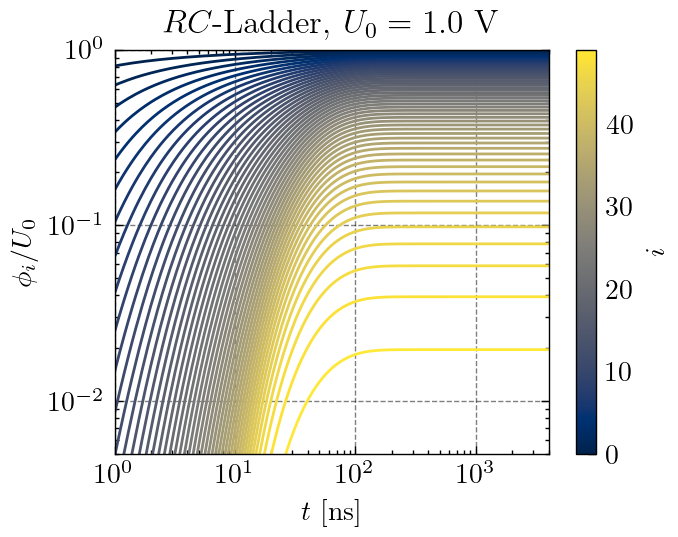

In [6]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)

for i in range(Np):
    ax.plot(t_vals*1e9, phi[i,:]/U0, color=cm(norm(i)))

ax.set_xlim(1,4000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_title(f"$RC$-Ladder, $U_0 = {U0}$ V")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")
fig.savefig("../plots/rc_ladder_pot_curves.svg", transparent=True)

Text(0.5, 0, '$n$')

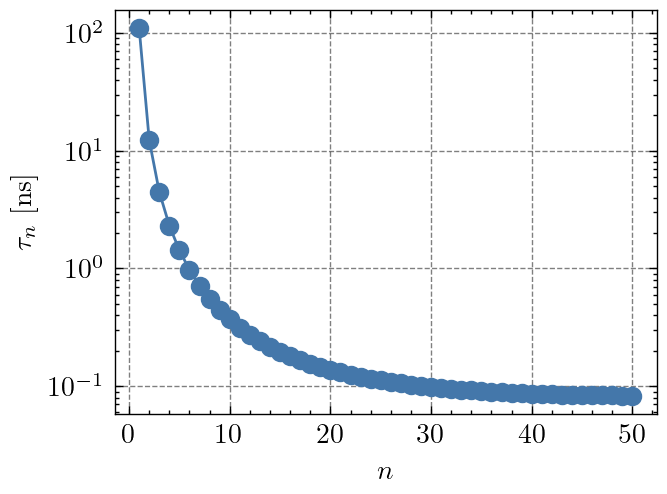

In [60]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(n_v,tau_n*1e9, '-o')
ax.set_yscale('log')
ax.set_ylabel("$\\tau_n$ [ns]")
ax.set_xlabel("$n$")

Text(0.5, 0, '$n$')

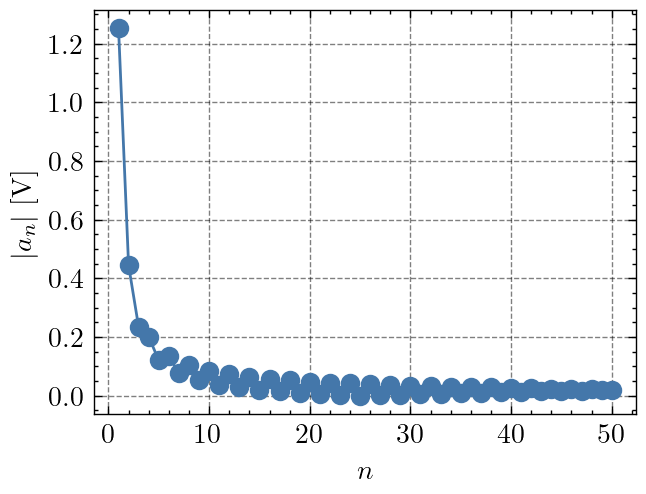

In [61]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
# ax.plot(n_v,a_vals)
ax.plot(n_v,np.abs(a_vals), '-o')
ax.set_ylabel("$|a_n|$ [V]")
ax.set_xlabel("$n$")

Text(0.5, 0, '$i$')

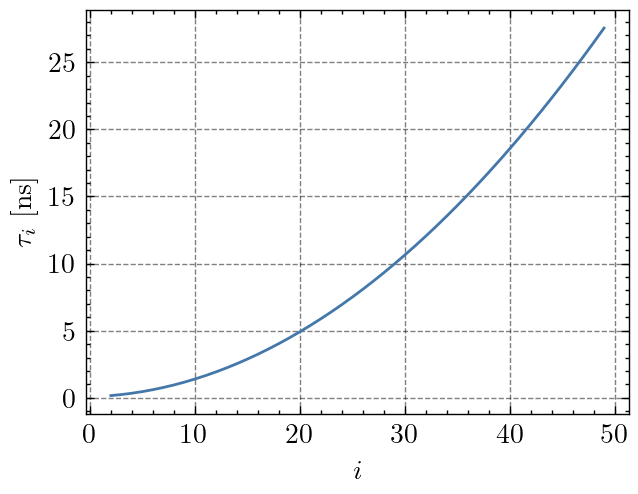

In [54]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(np.arange(2,50), tau_i_n0*1e9)
ax.set_ylabel("$\\tau_i$ [ns]")
ax.set_xlabel("$i$")

In [ ]:
def tau_i(i, N, R, Cm)

In [101]:
total   = 0.0
for n in range(1,N+1):
    weights = (a_vals[n-1] * np.sin(n * np.pi * i /(N + 1)))**2

array([-2.22067821e+07, -4.40713032e+07, -6.52663564e+07, -8.54934698e+07,
       -1.04494052e+08, -1.22057214e+08, -1.38023924e+08, -1.52287623e+08,
       -1.64791749e+08, -1.75524897e+08, -1.84514397e+08, -1.91819102e+08,
       -1.97522041e+08, -2.01723455e+08, -2.04534554e+08, -2.06072205e+08,
       -2.06454593e+08, -2.05797852e+08, -2.04213575e+08, -2.01807086e+08,
       -1.98676341e+08, -1.94911345e+08, -1.90593948e+08, -1.85797938e+08,
       -1.80589334e+08, -1.75026809e+08, -1.69162210e+08, -1.63041102e+08,
       -1.56703338e+08, -1.50183613e+08, -1.43511998e+08, -1.36714439e+08,
       -1.29813227e+08, -1.22827416e+08, -1.15773215e+08, -1.08664333e+08,
       -1.01512292e+08, -9.43267047e+07, -8.71155216e+07, -7.98852515e+07,
       -7.26411555e+07, -6.53874196e+07, -5.81273079e+07, -5.08632983e+07,
       -4.35972039e+07, -3.63302820e+07, -2.90633315e+07, -2.17967825e+07,
       -1.45307786e+07, -7.26525269e+06])

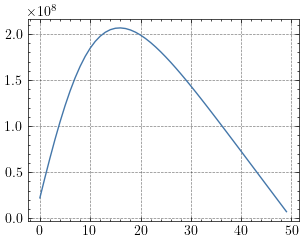

In [103]:
plt.plot(np.abs(a_vals)/tau_n)

In [3]:
from scipy.optimize import newton

def calculate_gamma(omega, R, Cm, Cs):
    """Compute the complex propagation constant gamma."""
    Ym = 1/R + 1j * omega * Cm  # Mutual admittance
    Ys = 1j * omega * Cs         # Self admittance
    
    # Define the equation for cosh(gamma) = 1 + Ys / (2 * Ym)
    def equation(gamma):
        return np.cosh(gamma) - (1 + Ys / (2 * Ym))
    
    # Initial guess for gamma (handles low and high frequencies)
    gamma_guess = np.sqrt(1j * omega * R * Cs) if omega < 1/(R*Cm) else np.arcosh(1 + Cs/(2*Cm))
    
    # Numerically solve for gamma
    gamma = newton(equation, gamma_guess)
    return gamma

def calculate_phi_i(omega, R, Cm, Cs, N, U0, i):
    """Compute the phasor voltage at node i."""
    gamma = calculate_gamma(omega, R, Cm, Cs)
    sinh = np.sinh  # Hyperbolic sine
    
    # Phasor solution (sinh-based form)
    phi_i_phasor = U0 * sinh(gamma * (N + 1 - i)) / sinh(gamma * (N + 1))
    return phi_i_phasor

def phi_i_time(t, omega, R, Cm, Cs, N, U0, i):
    """Compute the time-domain voltage at node i."""
    phi_i_phasor = calculate_phi_i(omega, R, Cm, Cs, N, U0, i)
    return np.imag(phi_i_phasor * np.exp(1j * omega * t))

In [18]:
phi_i_time(t_vals, omega, R, Cm, Cs, Np, U0, 2)

array([-0.02138367, -0.02078166, -0.02017964, ..., -0.02318966,
       -0.02258767, -0.02198567])

In [40]:
N_steps     = 40000
Np          = 50
R           = 25*1e6
U0          = 1.0
Cm          = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs          = self_capacitance_sphere(3.9, 10)
t_vals      = np.arange(N_steps)*1e-10
f0          = 1e5
omega       = 2*np.pi*f0

for i in range(1, Np + 1):
    phi_i = calculate_phi_i(omega, R, Cm, Cs, Np, U0, i)
    print(f"Node {i}: |{np.abs(phi_i):.4f}| V, ∠{np.angle(phi_i):.4f} rad")

phi_i_t = [phi_i_time(t_vals, omega, R, Cm, Cs, Np, U0, i) for i in range(1,Np+1)]

Node 1: |0.9804| V, ∠-0.0011 rad
Node 2: |0.9608| V, ∠-0.0023 rad
Node 3: |0.9411| V, ∠-0.0034 rad
Node 4: |0.9215| V, ∠-0.0045 rad
Node 5: |0.9019| V, ∠-0.0055 rad
Node 6: |0.8823| V, ∠-0.0065 rad
Node 7: |0.8627| V, ∠-0.0076 rad
Node 8: |0.8431| V, ∠-0.0085 rad
Node 9: |0.8235| V, ∠-0.0095 rad
Node 10: |0.8038| V, ∠-0.0105 rad
Node 11: |0.7842| V, ∠-0.0114 rad
Node 12: |0.7646| V, ∠-0.0123 rad
Node 13: |0.7450| V, ∠-0.0131 rad
Node 14: |0.7254| V, ∠-0.0140 rad
Node 15: |0.7058| V, ∠-0.0148 rad
Node 16: |0.6862| V, ∠-0.0156 rad
Node 17: |0.6666| V, ∠-0.0164 rad
Node 18: |0.6470| V, ∠-0.0172 rad
Node 19: |0.6274| V, ∠-0.0179 rad
Node 20: |0.6078| V, ∠-0.0186 rad
Node 21: |0.5881| V, ∠-0.0193 rad
Node 22: |0.5685| V, ∠-0.0200 rad
Node 23: |0.5489| V, ∠-0.0206 rad
Node 24: |0.5293| V, ∠-0.0213 rad
Node 25: |0.5097| V, ∠-0.0219 rad
Node 26: |0.4901| V, ∠-0.0224 rad
Node 27: |0.4705| V, ∠-0.0230 rad
Node 28: |0.4509| V, ∠-0.0235 rad
Node 29: |0.4313| V, ∠-0.0241 rad
Node 30: |0.4117| V, ∠-

Text(0, 0.5, '$\\phi_i(t)$ [V]')

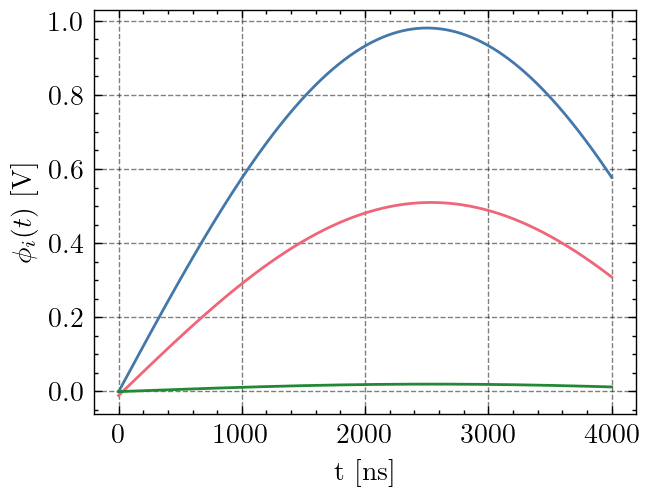

In [41]:
plt.figure(dpi=200)
plt.plot(t_vals*1e9, phi_i_t[0])
plt.plot(t_vals*1e9, phi_i_t[24])
plt.plot(t_vals*1e9, phi_i_t[49])
plt.xlabel("t [ns]")
plt.ylabel("$\phi_i(t)$ [V]")